In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from itertools import combinations
import random
from sklearn.neighbors import KNeighborsRegressor

from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Convolution2D, Dense, Flatten, MaxPooling2D, Lambda,Conv2DTranspose
from keras.optimizers import Adam

import cv2

Using TensorFlow backend.


In [2]:
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/u1000.npz')
u_n=npzfile['u']
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/v1000.npz')
v_n=npzfile['v']

In [3]:
u_n.shape

(1000, 512, 512)

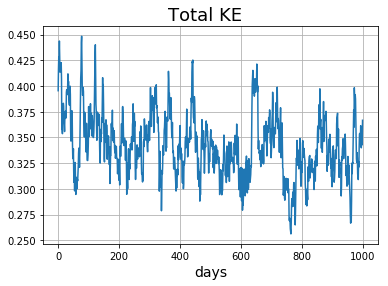

In [4]:
stp=np.arange(u_n.shape[0])
ekeu=((u_n**2).mean(axis=1)).mean(axis=1)
ekev=((v_n**2).mean(axis=1)).mean(axis=1)
plt.plot(stp[:],(ekeu+ekev)[:])
plt.title('Total KE  ', fontsize=18)
plt.xlabel('days', fontsize=14)
plt.grid()

In [5]:
dx = 2.5*1e3
l=12*dx#10*1e3
um_t=np.zeros(u_n.shape)
vm_t=np.zeros(u_n.shape)
for t in range( u_n.shape[0]) :
    um_t[t,:,:] = gaussian_filter( u_n[t,:,:], l/dx )
    vm_t[t,:,:] = gaussian_filter( v_n[t,:,:], l/dx )

In [ ]:
#WB
nx1=20
nx2=180
ny1=260
ny2=420

In [38]:
#EB
nx1=330
nx2=490
ny1=180
ny2=340

In [59]:
#Centre
nx1=150
nx2=310
ny1=10
ny2=170

In [7]:
u=u_n[:,ny1:ny2,nx1:nx2]
v=v_n[:,ny1:ny2,nx1:nx2]

um=um_t[:,ny1:ny2,nx1:nx2]
vm=vm_t[:,ny1:ny2,nx1:nx2]

ue=u-um
ve=v-vm

Text(0.5, 1.0, 'Snapshot  $\\overline{u} $')

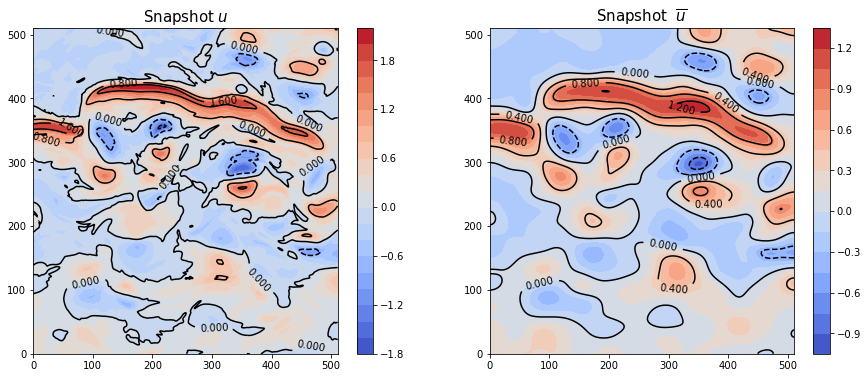

In [8]:
plt.figure(figsize=(15,6))
ni=805
plo=u_n
plm=um_t

plt.subplot(121)
plt.contourf(plo[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plo[ni],5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Snapshot $u$',fontsize=15)

plt.subplot(122)
plt.contourf(plm[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plm[ni],5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Snapshot  $\overline{u} $',fontsize=15)

Text(0.5, 1.0, 'Time mean  $\\overline{u} $')

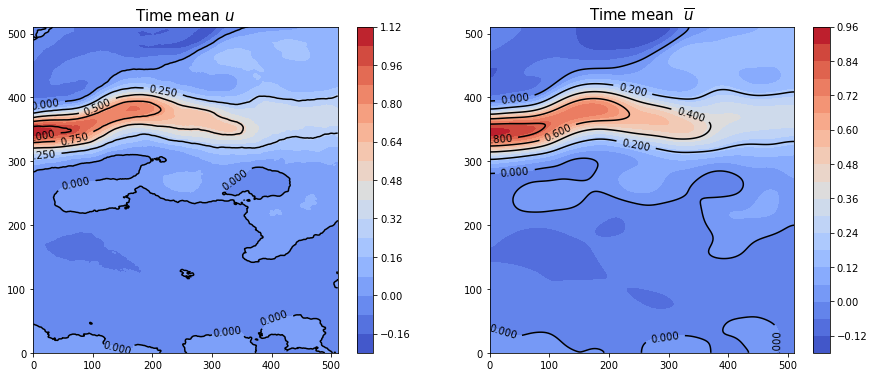

In [9]:
plt.figure(figsize=(15,6))

plo=u_n.mean(axis=0)
plm=um_t.mean(axis=0)

plt.subplot(121)
plt.contourf(plo,20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plo,5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Time mean $u$',fontsize=15)

plt.subplot(122)
plt.contourf(plm,20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plm,5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Time mean  $\overline{u} $',fontsize=15)

Text(0.5, 1.0, 'u eddy')

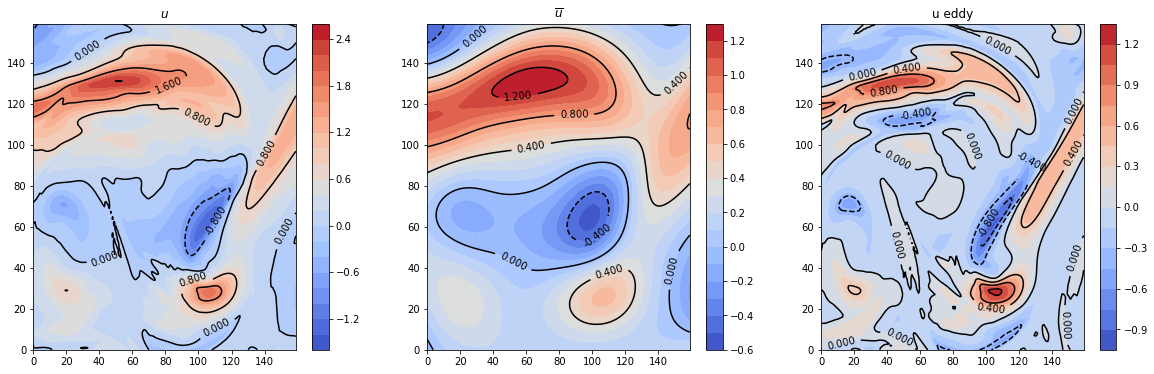

In [10]:
plt.figure(figsize=(20,6))
ni=20
plo=u
plm=um
ple=ue
plt.subplot(131)
plt.contourf(plo[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plo[ni],5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('$u$')

plt.subplot(132)
plt.contourf(plm[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plm[ni],5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('$\overline{u} $')

plt.subplot(133)
plt.contourf(ple[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(ple[ni],5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('u eddy')

########################################################################
# Data Preparation Functions
########################################################################

In [6]:
def calcEddyForcing(u1,v1,ubar,vbar):
    """
    Given the filtered-streamfunction 'psiBar' and the sub-filter
    streamfunction psiEddy = psi - psiBar, calculate the components
    of the sub-filter eddy momentum forcing Sx and Sy
    (Sx,Sy) = (U.grad)U - filter( (u.grad)u ),
    where U is the velocity from the filtered-streamfunction, and
    u is the full velocity (filtered + sub-filter).    The calculation
    requires more spatial-filtering, which is why the length-scale
    of the filter 'l' (in km) is required as an input variable.
    """

    # spatial-resolution of QG model (7.5km)
    dx = 2.5*1e3
    l=12*dx#10*1e3
    
    u=u1
    v=v1
    U=ubar
    V=vbar

    
    # Calcluate filtered-advection term
    [ U_t, U_y, U_x ] = np.gradient( U, dx );  del U_t
    [ V_t, V_y, V_x ] = np.gradient( V, dx );  del V_t

    # ( Ud/dx + Vd/dy )U and ( Ud/dx + Vd/dy )V
    adv1_x = U * U_x + V * U_y
    adv1_y = U * V_x + V * V_y

    del U_x, U_y, V_x, V_y

    # Calculate sub-filter advection term
    [u_t, u_y, u_x] = np.gradient(u, dx); del u_t
    [v_t, v_y, v_x] = np.gradient(v, dx); del v_t

    # ( ud/dx + vd/dy )u + ( ud/dx + vd/dy )v
    adv2_x = u * u_x + v * u_y
    adv2_y = u * v_x + v * v_y

    del u_x, u_y, v_x, v_y

    for t in range( adv2_x.shape[0] ) :
        adv2_x[t,:,:] = gaussian_filter( adv2_x[t,:,:], l/dx )
        adv2_y[t,:,:] = gaussian_filter( adv2_y[t,:,:], l/dx )

    # Calculate the eddy momentum forcing components
    Sx = adv1_x - adv2_x
    Sy = adv1_y - adv2_y

    return Sx, Sy

In [ ]:
Sx,Sy=calcEddyForcing(u,v,um,vm)
Sx.shape

In [16]:
def loadAndNormDataS(u_1,s_1,MOMENTUM_B=False ):
    nt=40
    nti=int(um.shape[0]*0.8)
 
    S=s_1
    psiFilt=u_1
    
    mu1, sigma1 = np.mean( psiFilt), np.std( psiFilt )
    mu2, sigma2 = np.mean( S ), np.std( S )
    
    psiFilt = (psiFilt - mu1) / sigma1
    S = (S - mu2) / sigma2

    scalings = [mu1, sigma1, mu2, sigma2]
    
    xTrain, xTest = psiFilt[:nti, :, :], psiFilt[nti:, :, :]
    yTrain, yTest = S[:nti, :, :], S[nti:, :, :]
    # split the original 160x160 region into 16 sub-regions
    # of size 40x40. Then combine into a single data set (which
    # will have sixteen times as many trainig samples).
    xTrain = np.reshape(np.array(np.split(np.array(np.split(xTrain, 4, axis=2)), 4, axis=2)), (4 * 4 * nti, nt, nt))
    yTrain = np.reshape(np.array(np.split(np.array(np.split(yTrain, 4, axis=2)), 4, axis=2)), (4 * 4 * nti, nt, nt))

    xTest = np.reshape(np.array(np.split(np.array(np.split(xTest, 4, axis=2)), 4, axis=2)), (4 * 4 * (ue.shape[0]-nti), nt, nt))
    yTest = np.reshape(np.array(np.split(np.array(np.split(yTest, 4, axis=2)), 4, axis=2)), (4 * 4 * (ue.shape[0]-nti), nt, nt))

    if MOMENTUM_B :
       # remove the spatial-mean of S, at each time-slice, in order to make
       # the net input of momentum zero in the training data (approach B to
       # conserving momentum by pre-processing training data).
        yTrain = yTrain - np.mean( yTrain, axis=(1,2), keepdims=True )
        yTest = yTest - np.mean( yTest, axis=(1,2), keepdims=True )

    # add singleton dimension for input variables (this is for Keras)
    xTrain = np.reshape(xTrain, (-1, nt, nt, 1))
    xTest = np.reshape(xTest, (-1, nt, nt, 1))

    # reshape outputs from 2D (40x40) to 1D vector 1600
    #yTrain = np.reshape(yTrain, (-1, nt * nt))  # For CNNs #1
    #yTest = np.reshape(yTest, (-1, nt * nt)) 
    yTrain = np.reshape(yTrain, (-1, nt, nt, 1)) # For CNNs #2
    yTest = np.reshape(yTest, (-1, nt, nt, 1))

    return xTrain, yTrain, xTest, yTest, scalings

In [17]:
xTrain, yTrain, xTest, yTest, scalings =loadAndNormDataS(um,Sx,MOMENTUM_B=False )
#xTrain, yTrain, xTest, yTest, scalings =makeSparseDataset(um,Sx,1000 )

Training Functions

In [68]:
# CNNs #1
def trainCNN_S(u_3,s_3 ) : 
    # load data 
    xTrain, yTrain, xTest, yTest, scalings = loadAndNormDataS(u_3,s_3,MOMENTUM_B=False )

    # number of training and validation samples
    nTrain = xTrain.shape[0]
    nTest = xTest.shape[0]

    print ("Number of training samples: ", nTrain)
    print ("Number of validation samples: ", nTest)

    ########## Construct Layers ##########

    input_layer = Input( shape=( 40, 40, 1 ) )

    # Convolution layers
    conv_1 = Convolution2D( 16, (8,8), strides=(2,2), padding='valid', activation='selu')( input_layer )
    conv_2 = Convolution2D( 8, (4,4), padding='valid', activation='selu')( conv_1 )
    conv_3 = Convolution2D( 8, (4,4), padding='valid', activation='selu')( conv_2 )
    #conv_4 = Convolution2D( 8, (4,4), padding='valid', activation='selu')( conv_3 )

    # Max Pooling
    pool_1 = MaxPooling2D( pool_size=(2,2) )( conv_3 )
   
    
    flat = Flatten()(pool_1)
    output_layer = Dense( units=40*40, activation='linear' )( flat )
       
    ########## Train CNN ###########

    myModel = Model( inputs=input_layer, outputs=output_layer )
    myOpt = Adam( lr=0.0001 )
    myModel.compile( loss='mean_squared_error', optimizer=myOpt )#,metrics=['accuracy']
    

    # show the architecture and the parameters
    print (myModel.summary())

    # train the model
    History = myModel.fit( xTrain, yTrain, batch_size=16, epochs=200, verbose=2, validation_data=( xTest, yTest )  )
    
    #fileName='model'
    #myModel.save( fileName + '.h5' )
    
    return myModel,History

In [18]:
# CNNs #2
def trainCNN_S(u_3,s_3 ) : 
    # load data 
    xTrain, yTrain, xTest, yTest, scalings = loadAndNormDataS(u_3,s_3,MOMENTUM_B=False )

    # number of training and validation samples
    nTrain = xTrain.shape[0]
    nTest = xTest.shape[0]

    print ("Number of training samples: ", nTrain)
    print ("Number of validation samples: ", nTest)

    ########## Construct Layers ##########

    input_layer = Input( shape=( 40, 40, 1 ) )

    # Convolution layers
    conv_1 = Convolution2D( 32, (9,9), padding='valid', activation='relu')( input_layer )
    conv_2 = Convolution2D( 16, (1,1), padding='valid', activation='relu')( conv_1 )
    output_layer = Conv2DTranspose(1,(9,9),padding='valid')(conv_2)
    

    # Max Pooling
    #pool_1 = MaxPooling2D( pool_size=(2,2) )( conv_3 )
   
    
    #flat = Flatten()(pool_1)
    #output_layer = Dense( units=40*40, activation='linear' )( flat )
       
    ########## Train CNN ###########

    myModel = Model( inputs=input_layer, outputs=output_layer )
    myOpt = Adam( lr=0.001 )
    myModel.compile( loss='mean_squared_error', optimizer=myOpt )#,metrics=['accuracy']
    

    # show the architecture and the parameters
    print (myModel.summary())

    # train the model
    History = myModel.fit( xTrain, yTrain, batch_size=128, epochs=200, verbose=2, validation_data=( xTest, yTest )  )
    
    #fileName='model'
    #myModel.save( fileName + '.h5' )
    
    return myModel,History

In [19]:
model,History=trainCNN_S(um,Sx)

Number of training samples:  12800
Number of validation samples:  3200
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2624      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        528       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 40, 40, 1)         1297      
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 12800 samples, validate on 3200 samples
Epoch 1/200
 - 7s - loss: 0

 - 8s - loss: 0.5332 - val_loss: 0.5030
Epoch 126/200
 - 7s - loss: 0.5337 - val_loss: 0.4985
Epoch 127/200
 - 6s - loss: 0.5321 - val_loss: 0.5021
Epoch 128/200
 - 6s - loss: 0.5437 - val_loss: 0.5198
Epoch 129/200
 - 6s - loss: 0.5415 - val_loss: 0.5053
Epoch 130/200
 - 8s - loss: 0.5388 - val_loss: 0.4969
Epoch 131/200
 - 6s - loss: 0.5364 - val_loss: 0.5058
Epoch 132/200
 - 6s - loss: 0.5243 - val_loss: 0.4962
Epoch 133/200
 - 6s - loss: 0.5317 - val_loss: 0.5505
Epoch 134/200
 - 6s - loss: 0.5399 - val_loss: 0.5351
Epoch 135/200
 - 6s - loss: 0.5326 - val_loss: 0.4890
Epoch 136/200
 - 6s - loss: 0.5314 - val_loss: 0.4875
Epoch 137/200
 - 6s - loss: 0.5307 - val_loss: 0.5259
Epoch 138/200
 - 6s - loss: 0.5250 - val_loss: 0.5073
Epoch 139/200
 - 6s - loss: 0.5262 - val_loss: 0.5056
Epoch 140/200
 - 6s - loss: 0.5440 - val_loss: 0.5149
Epoch 141/200
 - 6s - loss: 0.5244 - val_loss: 0.4897
Epoch 142/200
 - 7s - loss: 0.5370 - val_loss: 0.5032
Epoch 143/200
 - 7s - loss: 0.5430 - val_l

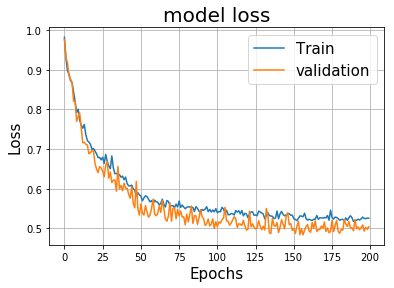

In [20]:
plt.figure()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('Loss', fontsize=15)  
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train','validation'], fontsize=15)#, loc='upper right'
#plt.savefig('modloss.png',dpi=150)
#files.download("modloss.png") 
plt.grid()
plt.show()

 Predicting Functions

In [21]:
def makeOverlapPreds(x, scl, model = model, MOMENTUM_A=False, MOMENTUM_B=False, MOMENTUM_C=False) :
    nt=40
    nti=int(x.shape[0]*0.8)
    scalings =scl
    shpx=x.shape[2]
    shpy=x.shape[1]
    mu1, sigma1, mu2, sigma2 = scalings[0], scalings[1], scalings[2], scalings[3]

    
    psiFilt = (x - mu1) / sigma1

    # We now want to make the predictions for the entire region, at every
    # time step. We move the neural network one grid point at a time over
    # the entire region, making predictions as it moves along. The predictions
    # at each grid point are then averaged.
    SPred = np.zeros( (x.shape[0]-nti,shpy,shpx) )
    
    mask = np.zeros( (shpy,shpx) )

    stride = 2

    for i in range( 0, shpx-nt+1, stride):   # loop through points in x

       #print (i)  # progress update
       for j in range( 0, shpy-nt+1, stride ):   # loop through points in y

          # make predictions at this point
         SPred[:,j:j+nt,i:i+nt] += model.predict( np.reshape( psiFilt[nti:,j:j+nt,i:i+nt], (-1,nt,nt,1) ) ).reshape( (-1,nt,nt) )

          # update number of predictions made at each grid point
         mask[j:j+nt,i:i+nt] += 1

    # average the predictions
    SPred = np.divide( SPred, mask )

    # rescale psi, either Sx or Sy
    
    SPred = SPred * sigma2 + mu2

    return SPred

In [ ]:
Spr=makeOverlapPreds(um_t,scalings)

In [7]:
SxTrue, SyTrue = calcEddyForcing(u_n,v_n,um_t,vm_t)

In [ ]:
nti=int(um.shape[0]*.8)
plt.figure(figsize=(15,6))
ni=5
plt.subplot(121)
plt.pcolor(SxTrue[nti+ni,10:-10,10:-10]*1e6,cmap='coolwarm',vmax=5,vmin=-5)#,,
cb=plt.colorbar()
plt.title('Snapshot True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)
plt.subplot(122)
pa=(Spr[ni])*1e6
plt.pcolor(pa[10:-10,10:-10],cmap='coolwarm',vmax=5,vmin=-5)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('Pred ',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

Text(0.5, 1.0, 'Time mean Prediction(1e6)')

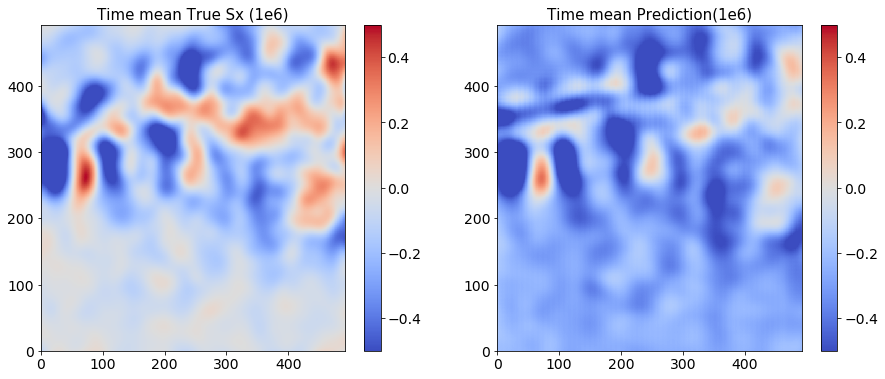

In [56]:
plt.figure(figsize=(15,6))
ni=5
#nti=int(um.shape[0]*0.8)
plo=SxTrue[-200:].mean(axis=0)
plm=Spr[-200:].mean(axis=0)


plt.subplot(121)
c=plt.pcolor(plo[10:-10,10:-10]*1.e6,cmap='coolwarm',vmin=-.5, vmax=.5)#,vmin=-4, vmax=5
cb=plt.colorbar(c)
#CS1=plt.contour(xl,yl,plo,5,colors = ('k',));# 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Time mean True Sx ($10^6 ms^{-2}$ )',fontsize=15)

plt.subplot(122)
pa=(plm)*1.e6
c1=plt.pcolor(pa[10:-10,10:-10],cmap='coolwarm',vmax=-.5,vmin=.5)#vmin=-4, vmax=5
cb=plt.colorbar()
#CS1=plt.contour(xl,yl,plm,5,colors = ('k',)); 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Time mean Prediction ($10^6 ms^{-2}$ )',fontsize=15)

In [94]:
nti=int(um.shape[0]*0.8)
sp=Spr[:]
sxt=SxTrue[nti:]

rms2=np.zeros((sxt.shape[1],sxt.shape[2]))
for xi in range (sxt.shape[2]):
    for yi in range (sxt.shape[1]):
        rms2[yi,xi] = np.sqrt(mean_squared_error(sxt[:,yi,xi], sp[:,yi,xi]))
rms2[:,20:-20].mean()*1e6

0.7691593695441354

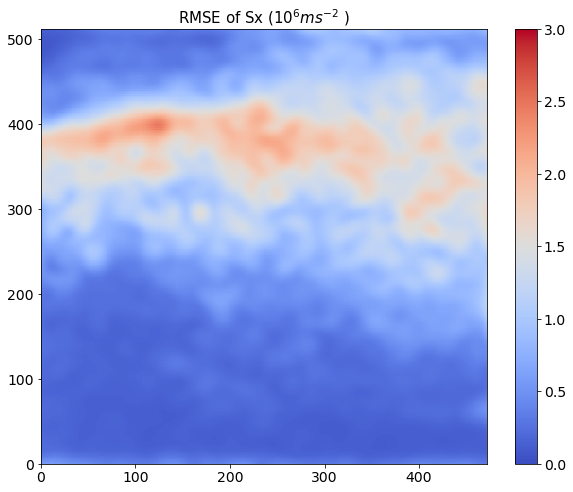

In [95]:
plt.figure(figsize=(10,8))
plt.pcolor(rms2[:,20:-20]*1e6,vmin=0,vmax=3,cmap='coolwarm')
plt.colorbar()
plt.title('RMSE of Sx ($10^6 ms^{-2}$ )',fontsize=15)
plt.rc('xtick',labelsize=14)

In [36]:
ncf=np.zeros((sxt.shape[1],sxt.shape[2]))
for ni in range(sxt.shape[1]):
    for nj in range(sxt.shape[2]):
        ncf[ni,nj]= np.corrcoef(sxt[:,ni,nj],sp[:,ni,nj])[1,0]   

NameError: name 'sxt' is not defined

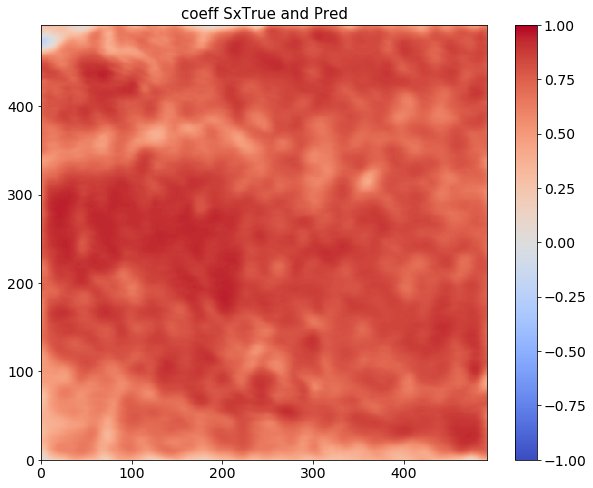

In [41]:
plt.figure(figsize=(10,8))
plt.pcolor(ncf,vmin=-1,vmax=1,cmap='coolwarm')
plt.colorbar()
plt.title('coeff SxTrue and Pred',fontsize=15)
plt.rc('xtick',labelsize=14)